# Substructure Challenge - Mock production notebook
This notebook leads through a procedure to produce (realistic) mock images with the lenstronomy software package. Be aware of the nummerics involved. The notebook goes through the follwing steps:
1. define a (realistic) lens model with a lot of substructure
2. decompose a nearby galaxy in high order shapelet coefficients
3. lens the decomposed image through the lens model
4. add a lens light profile to the image
5. turn the simulation to (realistic) data by applying a PSF convolution and define the pixel size.

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) or via pypi
- relative path to files contained in the lenstronomy_extension repository (https://github.com/sibirrer/lenstronomy_extensions)

The packages are based on Birrer, Amara & Refregier 2015 and the official release is presented in  Birrer & Amara 2018.

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

To get to know more about the lenstronomy, please consider also other example notebooks.

In [1]:
# import standard python libraries
import numpy as np
import scipy
import os
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util

## 1. Define a lens model
Here we define a lens model consistent of one main halo and quite some subclumps with some simple rendering description.

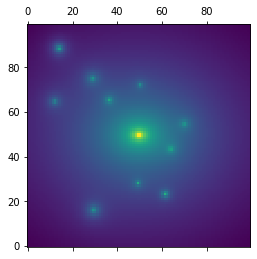

In [2]:

# define the lens model of the main deflector
main_halo_type = 'SIE'  # You have many other possibilities available. Check out the SinglePlane class!
kwargs_lens_main = {'theta_E': 1., 'e1': 0.1, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
lens_model_list = [main_halo_type, 'SHEAR']
kwargs_lens_list = [kwargs_lens_main, kwargs_shear]

subhalo_type = 'TNFW'  # We chose spherical NFW profiles, feel free to chose whatever you want.

# as an example, we render some sub-halos with a very simple distribution to be added on the main lens
num_subhalo = 10  # number of subhalos to be rendered
# the parameterization of the NFW profiles are:
# - Rs (radius of the scale parameter Rs in units of angles)
# - theta_Rs (radial deflection angle at Rs)
# - center_x, center_y, (position of the centre of the profile in angular units)

Rs_mean = 0.1
Rs_sigma = 0.1  # dex scatter
theta_Rs_mean = 0.05
theta_Rs_sigma = 0.1 # dex scatter
r_min, r_max = -2, 2

Rs_list = 10**(np.log10(Rs_mean) + np.random.normal(loc=0, scale=Rs_sigma, size=num_subhalo))
theta_Rs_list = 10**(np.log10(theta_Rs_mean) + np.random.normal(loc=0, scale=theta_Rs_sigma, size=num_subhalo))
center_x_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
center_y_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
for i in range(num_subhalo):
    lens_model_list.append(subhalo_type)
    kwargs_lens_list.append({'alpha_Rs': theta_Rs_list[i], 'Rs': Rs_list[i],
                             'center_x': center_x_list[i], 'center_y': center_y_list[i],
                            'r_trunc': 5*Rs_list[i]
                            })

# now we define a LensModel class of all the lens models combined
from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)
# we set up a grid in coordinates and evaluate basic lensing quantities on it
x_grid, y_grid = util.make_grid(numPix=100, deltapix=0.05)
kappa = lensModel.kappa(x_grid, y_grid, kwargs_lens_list)
# we make a 2d array out of the 1d grid points
kappa = util.array2image(kappa)
# and plot the convergence of the lens model
plt.matshow(np.log10(kappa), origin='lower')
plt.show()

## Optical vs physical units

All lenstronomy parameters are in angular (e.g. reduced deflections) units and purely describe the optics independent of cosmology. For an NFW profile, you can use the following method to translate a physical halo to lenstronomy:

In [3]:
z_lens = 0.5
z_source = 2
from astropy.cosmology import default_cosmology
cosmo = default_cosmology.get()
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# class that converts angular to physical units for a specific cosmology and redshift configuration
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# here we turn an NFW halo defined as M200 crit and concentration into lensing quantities
M200 = 10**9
concentration = 6
Rs_angle_clump, theta_Rs_clump = lensCosmo.nfw_physical2angle(M=M200, c=concentration)
print(Rs_angle_clump, theta_Rs_clump)

# and here we do the oposite and turn the lensing quantities into physical units
rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump = lensCosmo.nfw_angle2physical(Rs_angle_clump, theta_Rs_clump)
print(rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump)

0.46515249148844084 0.002411501895446134
2920676532624540.0 0.002924986525384787 6.0 0.017549919152308722 1000000000.0000011


## 2. decompose a nearby galaxy in high order shapelet coefficients
Here we read in an image and decompose it in shapelet coefficient. We then use the coefficients to re-create the image (sort of like a Furier decomposition)

In [4]:
# import NGC1300 jpg image and decompose it
import imageio

# find path to data
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'Data/Galaxies/ngc1300.jpg')
# read data, this only works if you execute this notebook within the environment of the github repo!
ngc_data = imageio.imread(ngc_filename, as_gray=True, pilmode=None)

# subtract the median of an edge of the image
median = np.median(ngc_data[:200, :200])
ngc_data -= median

# resize the image to square size (add zeros at the edges of the non-square bits of the image)
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx)/2.)
y_start = int((n_max - ny)/2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# we slightly convolve the image with a Gaussian convolution kernel of a few pixels (optional)
sigma = 5
ngc_conv = scipy.ndimage.filters.gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)

# we now degrate the pixel resoluton by a factor.
# This reduces the data volume and increases the spead of the Shapelet decomposition
factor = 25  # lower resolution of image with a given factor
numPix_large = int(len(ngc_conv)/factor)
n_new = int((numPix_large-1)*factor)
ngc_cut = ngc_conv[0:n_new,0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # re-size image to lower resolution

# now we come to the Shapelet decomposition
# we turn the image in a single 1d array
image_1d = util.image2array(ngc_data_resized)  # map 2d image in 1d data array



11476 number of coefficients


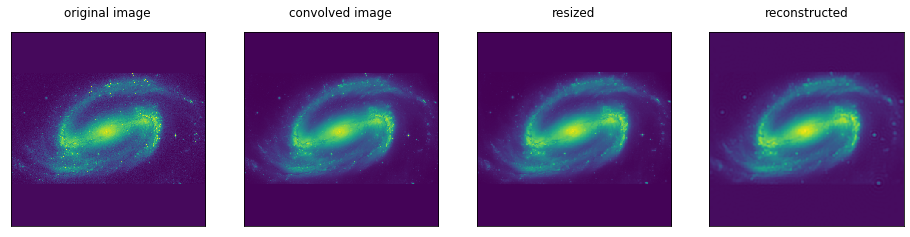

In [5]:
# we define the shapelet basis set we want the image to decompose in
n_max = 150  # choice of number of shapelet basis functions, 150 is a high resolution number, but takes long
beta = 10  # shapelet scale parameter (in units of resized pixels)

# import the ShapeletSet class
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapeletSet = ShapeletSet()

# decompose image and return the shapelet coefficients
coeff_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0) 
print(len(coeff_ngc), 'number of coefficients')  # number of coefficients

# reconstruct NGC1300 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, coeff_ngc, n_max, beta, center_x=0, center_y=0)
# turn 1d array back into 2d image
image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image

f, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow(ngc_square, origin='lower')
ax.set_title("original image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
im = ax.matshow(ngc_conv, origin='lower')
ax.set_title("convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow(ngc_data_resized, origin='lower')
ax.set_title("resized")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow(image_reconstructed_2d, origin='lower')
ax.set_title("reconstructed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

## 3. lens the decomposed image through the lens model
now we combine the lens model and the galaxy (their shapelet coefficients) in producing a lensed image through backwards ray-tracing.

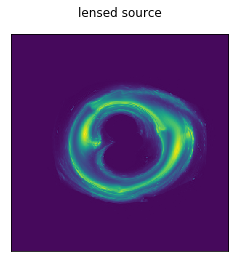

In [6]:
# we define a very high resolution grid for the ray-tracing (needs to be checked to be accurate enough!)
numPix = 100  # number of pixels (low res of data)
deltaPix = 0.05  # pixel size (low res of data)
high_res_factor = 3  # higher resolution factor (per axis)
# make the high resolution grid 
theta_x_high_res, theta_y_high_res = util.make_grid(numPix=numPix*high_res_factor, deltapix=deltaPix/high_res_factor)
# ray-shoot the image plane coordinates (angles) to the source plane (angles)
beta_x_high_res, beta_y_high_res = lensModel.ray_shooting(theta_x_high_res, theta_y_high_res, kwargs=kwargs_lens_list)

# now we do the same as in Section 2, we just evaluate the shapelet functions in the new coordinate system of the source plane
# Attention, now the units are not pixels but angles! So we have to define the size and position.
# This is simply by chosing a beta (Gaussian width of the Shapelets) and a new center

source_lensed = shapeletSet.function(beta_x_high_res, beta_y_high_res, coeff_ngc, n_max, beta=.05, center_x=0.2, center_y=0)
# and turn the 1d vector back into a 2d array
source_lensed = util.array2image(source_lensed)  # map 1d data vector in 2d image

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed, origin='lower')
ax.set_title("lensed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()



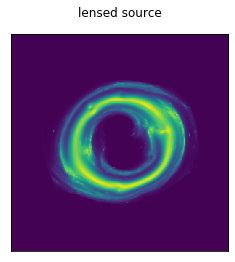

In [7]:
# here we perform the surface brightness computation with an interpolation function instead of the shapelets decomposition
# for high orders, this may be computationally more effective
kwargs_interp = {'image': ngc_data_resized, 'center_x': 0, 'center_y': 0, 'scale': 0.005, 'phi_G':0.2}
from lenstronomy.LightModel.Profiles.interpolation import Interpol
interp_light = Interpol()


source_lensed_interp = interp_light.function(beta_x_high_res, beta_y_high_res, **kwargs_interp)
# and turn the 1d vector back into a 2d array
source_lensed_interp = util.array2image(source_lensed_interp)  # map 1d data vector in 2d image

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed_interp, origin='lower')
ax.set_title("lensed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()



## 4. add a lens light profile to the image
Now we add a lens light profile. In principle we can just take another image and stack it on top of the lensed source. Instead we choe here parameterised Sersic profiles to represent the lensing host galaxy (might be over-simplified).

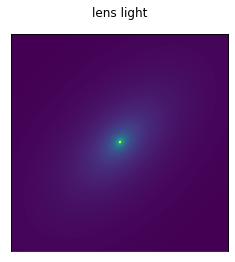

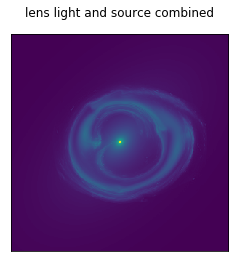

In [8]:
# import the LightModel class
from lenstronomy.LightModel.light_model import LightModel
# define a light mode, in our case the superposition of two elliptical Sersic profiles
light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
kwargs_lens_light = [
    {'amp': 20, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
    {'amp': 30, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
]
lensLightModel = LightModel(light_model_list=light_model_list)
# evaluate the surface brightness of the unlensed coordinates
flux_lens_light = lensLightModel.surface_brightness(theta_x_high_res, theta_y_high_res, kwargs_lens_light)
flux_lens_light = util.array2image(flux_lens_light)

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(flux_lens_light, origin='lower')
ax.set_title("lens light")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# and now we combine the two components
image_combined = source_lensed + flux_lens_light

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(image_combined, origin='lower')
ax.set_title("lens light and source combined")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## 5. turn the simulation into (realistic) imaging data
The following steps need to be done to turn the simulated lens into imaging data (or even more things to be considered):
- The convolution through a PSF
- estimate the flux corresponding to each (finite) pixel
- simulate the Poisson noise contribution from the sources (count statistic)
- simulate other noise sources, such as sky brightness, readout noise, etc
- simulate data reduction pipeline (e.g. drizzling etc, not part of this notebook)

### 5.1 PSF convolution

First we need a PSF kernel of the same resolution as our ray-tracing grid to do so, we import a TinyTim HST PSF of the original pixel size and sub-sample it with an iterative procedure (a bit black magic and not guaranteed to give the true underlinig higher resolution PSF).

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


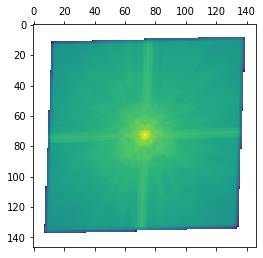

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


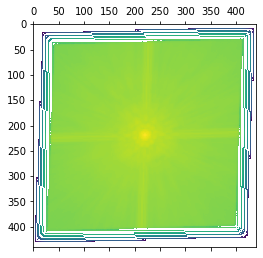

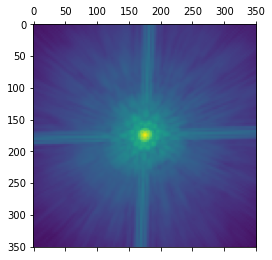

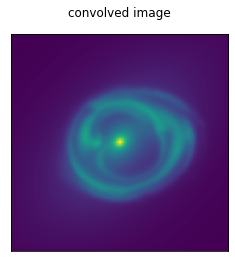

In [9]:
# import TinyTim PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

# subsample PSF to the high_res_factor scaling
import lenstronomy.Util.kernel_util as kernel_util
kernel_subsampled = kernel_util.subgrid_kernel(kernel, high_res_factor, odd=True, num_iter=5)
plt.matshow(np.log10(kernel_subsampled))
plt.show()

# we cut the PSF a tiny bit on the edges
kernel_subsampled = kernel_util.cut_psf(psf_data=kernel_subsampled, psf_size=len(kernel_subsampled)-30*high_res_factor)
plt.matshow(np.log10(kernel_subsampled))
plt.show()

# and now we perform the convolution with the scipy built in routine fftconvolve
import scipy.signal as signal
image_convolved = signal.fftconvolve(image_combined, kernel_subsampled, mode='same')

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(image_convolved, origin='lower')
ax.set_title("convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

### 5.2 down-sample the resolution ot the pixel size

Mathematicallly, you have to perform the integral of the convolved surface brightness over the size of each pixel. Computationally, we simply average over all those subsampled pixels that are contained within one pixel (only works when the subsampling grid was delibrately designed to do so).

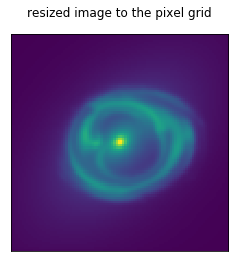

In [10]:
image_conv_resized = image_util.re_size(image_convolved, high_res_factor)

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(image_conv_resized, origin='lower')
ax.set_title("resized image to the pixel grid")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

### 5.3 add Poisson noise contribution from the sources
Here we role the dice based on the expected Poisson noise originated from the finite count statistic of the photons arriving on the detector from the sources simulated. A few notes to this:
- be aware of the pixel units (electrons != IID photons) and effective exposure time per pixel
- in the example below, we approximate the Poisson distribution with a Gaussian, this will fail for very low number counts where a photon-by-photon rendering must be undertaken (before the convolution kernel being applied).
- in the particular example here, the units are the total number of photons collected. If you deal with electrons, you need to know the CCD gain to estimate the IID component.

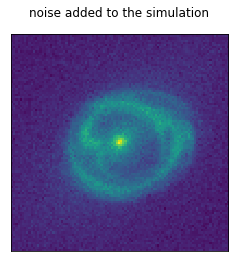

In [11]:
exposure_time = 1  # the units are photons and therefore the exposure time is unity
poisson = image_util.add_poisson(image_conv_resized, exp_time=exposure_time)

# and we add here another Gaussian component uniform over the entire image (just because it's easy)
background_rms = 10  # background rms
bkg = image_util.add_background(image_conv_resized, sigma_bkd=background_rms)

# and we add them all together
image_noisy = image_conv_resized + poisson + bkg

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(image_noisy, origin='lower')
ax.set_title("noise added to the simulation")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## Find the clumps!
Well, that's the challenge I guess :-)
If you can't see the clumps by eye, I'll help you with this example.
Here they are:

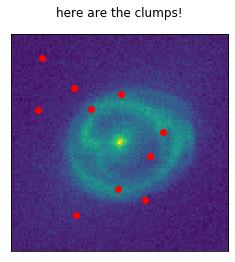

In [12]:
from lenstronomy.Data.coord_transforms import Coordinates
x_grid, y_grid, ra_at_xy_0, dec_at_xy_0, x_at_radec_0, y_at_radec_0, Mpix2coord, Mcoord2pix = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, inverse=False)
coordinates = Coordinates(ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0, transform_pix2angle=Mpix2coord)

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(image_noisy, origin='lower')
ax.set_title("here are the clumps!")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)


for i in range(2, len(lens_model_list)):
    kwargs = kwargs_lens_list[i]
    x_pos, y_pos = coordinates.map_coord2pix(kwargs['center_x'], kwargs['center_y'])
    ax.plot(x_pos, y_pos, 'or')
plt.show()